## 1. Data Preparation and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

# Load data
final_db = pd.read_csv('../01_data/final_data.csv')

# Define the target variable
def check_discrimination(row):
    if any(row[col] == 1 for col in ['EUD01_09', 'EUD01_96', 'EUD01_97', 'EUD01_99']):
        return 0  # No discrimination occurred
    elif any(row[col] == 1 for col in ['EUD01_01', 'EUD01_02', 'EUD01_03', 'EUD01_04', 
                                       'EUD01_05', 'EUD01_06', 'EUD01_07', 'EUD01_08']):
        return 1  # Discrimination occurred

# Create the binary discrimination variable
final_db['discrimination_occurred'] = final_db.apply(check_discrimination, axis=1)

# Drop variables used to construct discrimination_occurred
final_db.drop(['EUD01_01', 'EUD01_02', 'EUD01_03', 'EUD01_04', 
               'EUD01_05', 'EUD01_06', 'EUD01_07', 'EUD01_08',
               'EUD01_09', 'EUD01_96', 'EUD01_97', 'EUD01_99', 'country2'], axis=1, inplace=True) 

# Check distribution of the binary discrimination variable
print(final_db['discrimination_occurred'].value_counts())

discrimination_occurred
0    8236
1    5170
Name: count, dtype: int64


In [2]:
final_db.head()

,country,IN02,HH02,VV10_2,activ,id,VH01a_1_mod,VH01a_2_mod,VH01a_3_mod,VH01a_4_mod,...,PB10_2_mod,DHO01_mod,HH03_mod,DE06_mod,DHE04_mod,DHE03_mod,DHE02_mod,DO27_mod,DO24_mod,discrimination_occurred
0,1.0,8.0,37.0,2.0,1.0,165.0,2.0,1.0,0.0,0.0,...,1,1,0,1,1,3.0,0,1,0,1
1,1.0,8.0,30.0,2.0,1.0,317.0,0.0,0.0,0.0,0.0,...,1,1,0,1,1,3.0,0,1,0,0
2,1.0,8.0,35.0,2.0,1.0,321.0,1.0,0.0,0.0,0.0,...,1,1,0,0,1,3.0,0,1,0,0
3,1.0,8.0,42.0,1.0,2.0,322.0,7.0,0.0,7.0,0.0,...,1,0,0,1,1,1.0,1,1,0,1
4,1.0,8.0,39.0,2.0,7.0,327.0,0.0,0.0,1.0,0.0,...,0,1,0,0,1,3.0,0,1,0,0


In [3]:
# Split data
X = final_db.drop(['discrimination_occurred'], axis=1)
y = final_db['discrimination_occurred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

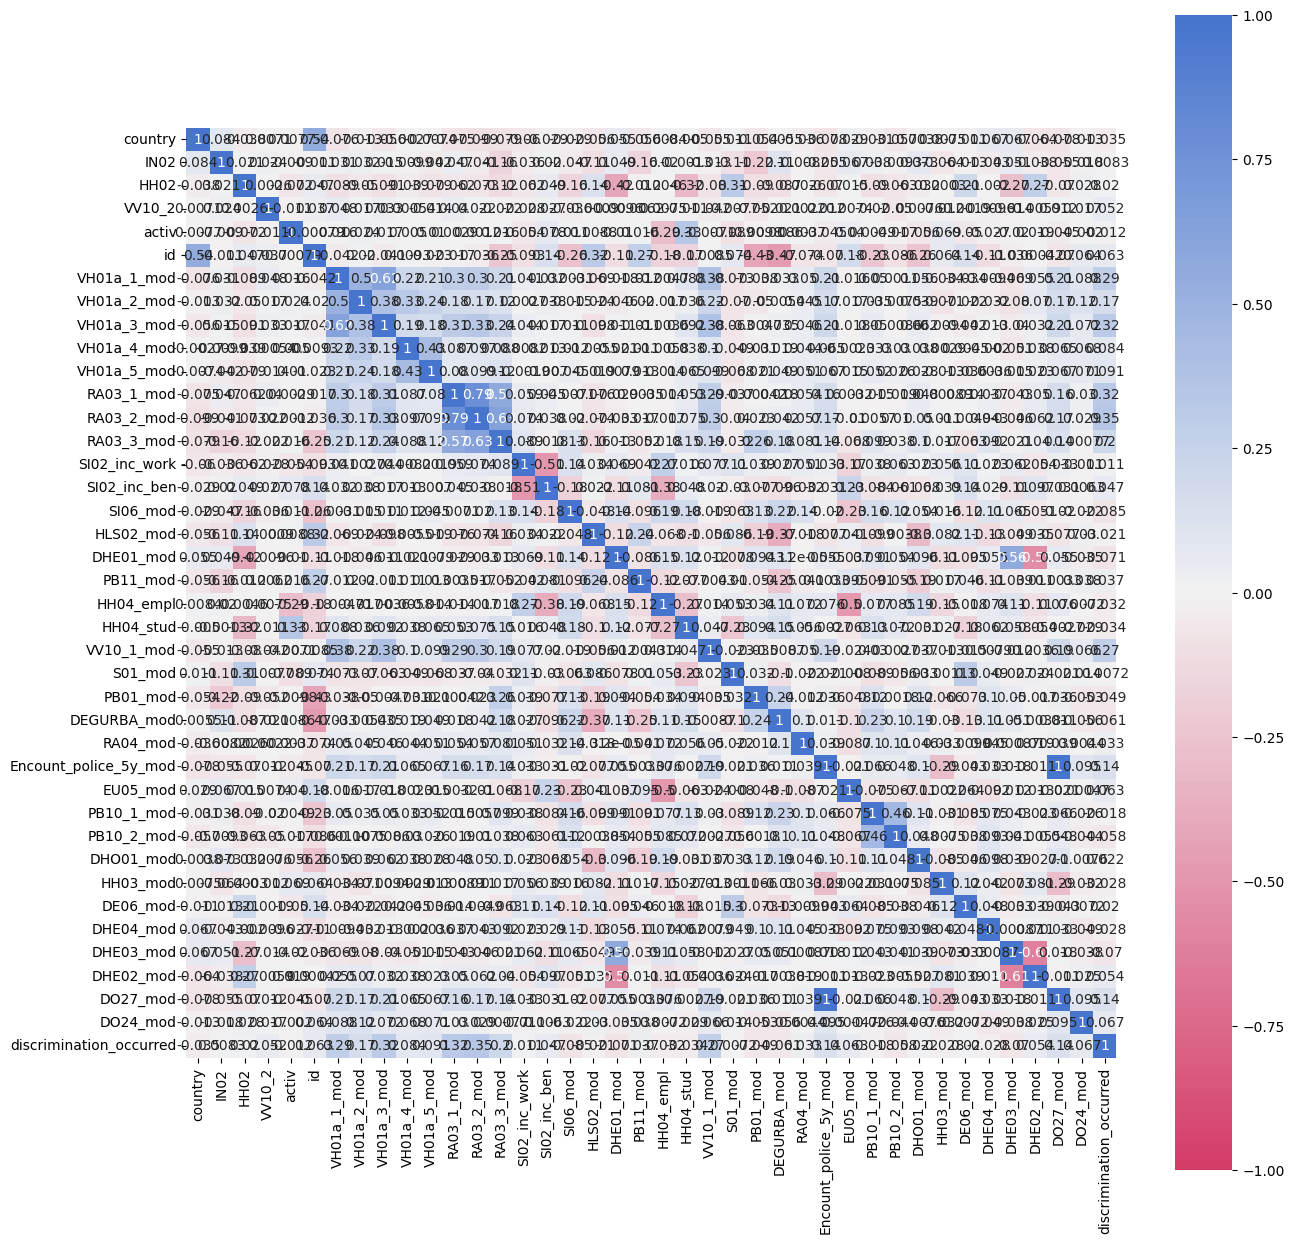

In [4]:
# Calculate correlation matrix
corr = final_db.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 256, n=200),
    square=True,
    ax=ax,
    annot=True
)
plt.show()

## 2. Model Building and Evaluation

Accuracy for Random Forest: 0.7284932869219294
Random Forest Cross-Validation Accuracy: 0.7244243240756413


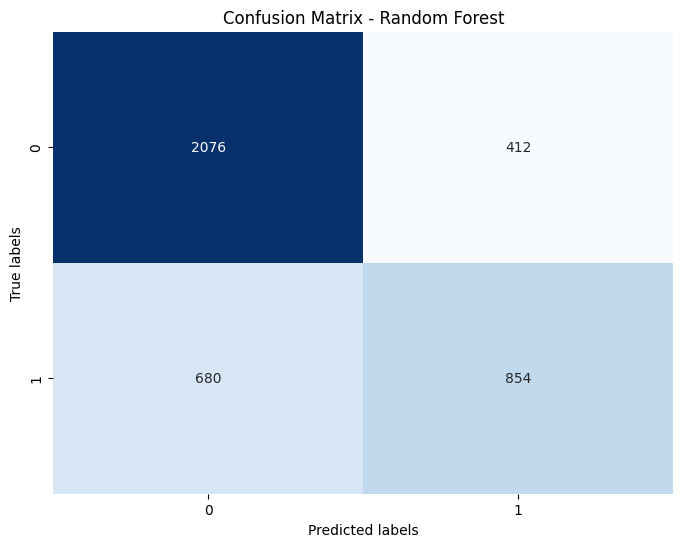

Accuracy for Logistic Regression: 0.7180507210343113
Logistic Regression Cross-Validation Accuracy: 0.7146208791645698


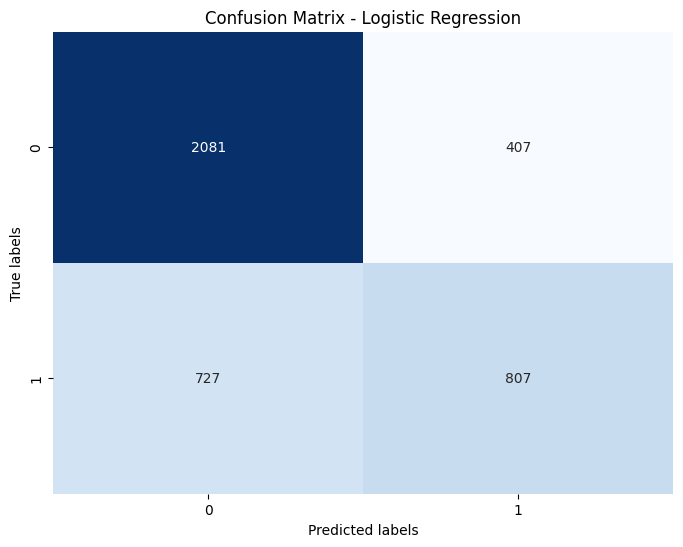

Accuracy for XGBoost: 0.7160616608652411
XGBoost Cross-Validation Accuracy: 0.7177101212864061


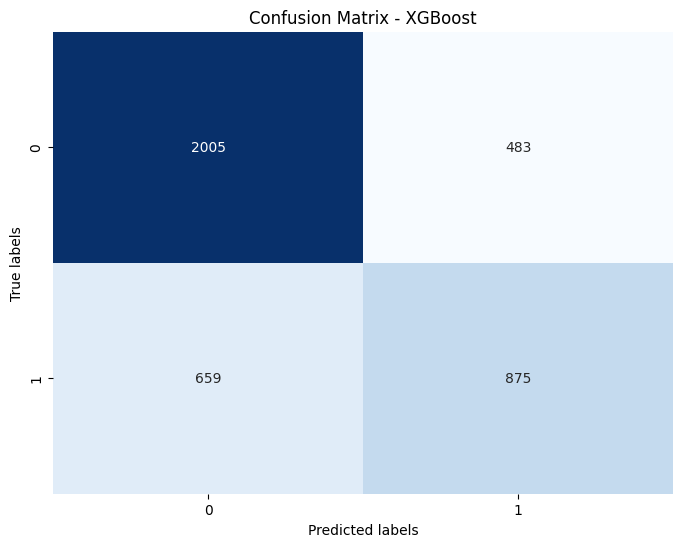

In [5]:
# Define preprocessing steps
preprocessor = StandardScaler()

# Define models
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create pipelines for each model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr)])
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb)])

# Train and evaluate models
models = [rf_pipeline, lr_pipeline, xgb_pipeline]
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']

for model, name in zip(models, model_names):
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy for {name}: {accuracy}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean()}")
    
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

## Feature Importance and Hyperparameter Tuning

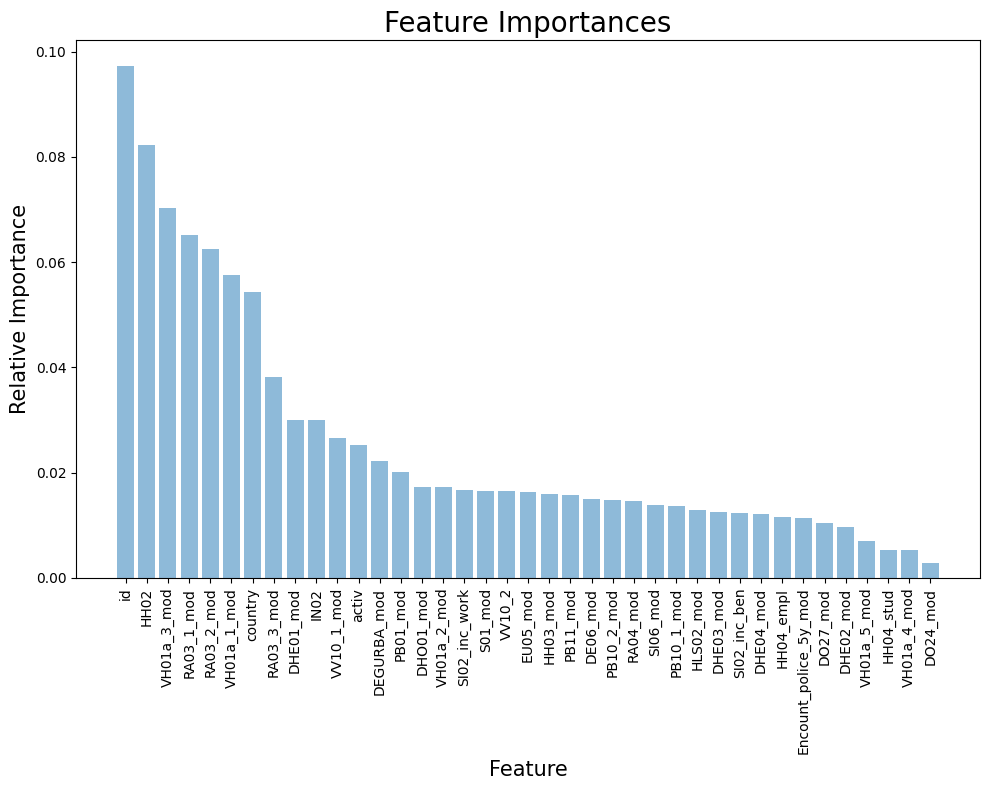

Best parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}


In [66]:
# Feature Importance
feature_importances = rf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances', fontsize=20)
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.ylabel('Relative Importance', fontsize=15)
plt.xlabel('Feature', fontsize=15)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
cv_rf.fit(X_train_scaled, y_train)

print("Best parameters:", cv_rf.best_params_)

In [58]:
## Best parameters
best_params = cv_rf.best_params_
print("Best parameters:", best_params)

# Use best parameters to retrain the model
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Evaluate the model with best parameters
best_rf_score = best_rf.score(X_test_scaled, y_test)
print("Accuracy with best parameters:", best_rf_score)

Best parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy with best parameters: 0.7274987568373943
